In [1]:
import numpy as np
import matplotlib.pyplot as plt

sample_rate = 1e6
N = 10000 # number of samples to simulate

# Create a tone to act as the transmitter signal
t = np.arange(N)/sample_rate # time vector
f_tone = 0.02e6
tx = np.exp(2j * np.pi * f_tone * t)


In [2]:
d = 0.5 # half wavelength spacing
Nr = 5
theta_degrees = 93 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Steering Vector
print(a) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j         -0.99999073-0.00430543j  0.99996293+0.00861078j
 -0.99991659-0.01291597j  0.99985171+0.01722092j]


In [3]:
a = a.reshape(-1,1)
print(a.shape) # 3x1
tx = tx.reshape(-1,1)
print(tx.shape) # 10000x1

# matrix multiply
r = a @ tx.T  # dont get too caught up by the transpose, the important thing is we're multiplying the Steering Vector by the tx signal
print(r.shape) # 3x10000.  r is now going to be a 2D array, 1D is time and 1D is the spatial dimension
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
r = r + 0.5*n # r and n are both 3x10000


(5, 1)
(10000, 1)
(5, 10000)


In [4]:
n

array([[-0.56269961+1.03273196j, -0.25958236-2.25316808j,
        -0.92769733+0.20431265j, ..., -0.24793521+0.46101832j,
        -0.01923525-0.21814323j,  1.82384299-0.84444848j],
       [ 0.69594102+0.28542742j,  1.44679884+0.38158879j,
         2.147218  +0.36508084j, ...,  0.68506361+0.39079159j,
        -0.62788136+0.48835835j, -0.63928803+0.76063025j],
       [-0.60028567-1.04913341j, -2.10401157+1.20232878j,
        -0.09136438-0.12404347j, ..., -1.09585431-0.99800658j,
         1.68165008-1.60423139j,  0.93963274+1.90071461j],
       [ 1.19403511-0.61492003j,  1.75457864+0.82860956j,
        -1.31197271-1.43324358j, ..., -0.15604451-0.39491113j,
        -0.6792661 -0.67412631j,  0.12982156+0.14056393j],
       [ 1.36983874+1.13203775j,  0.17857159+0.69910837j,
         1.857693  -0.69300487j, ...,  1.09816574-1.06520895j,
        -0.80289959-0.69234836j, -1.03381465-0.74005594j]])

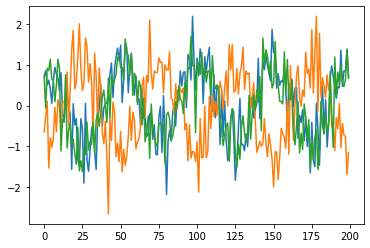

In [5]:
plt.plot(np.asarray(r[0,:]).squeeze().real[0:200]) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
plt.plot(np.asarray(r[1,:]).squeeze().real[0:200])
plt.plot(np.asarray(r[2,:]).squeeze().real[0:200])
plt.show()

In [6]:
num_expected_signals = 3

In [7]:
r.shape

(5, 10000)

In [8]:
R = r @ r.conj().T
R

array([[ 14932.39116611  +0.j        ,  -9918.70728841 +62.31071235j,
          9918.24743052 +56.16319961j, -10071.15261971 +50.29693729j,
          9947.65541737-200.8665221j ],
       [ -9918.70728841 -62.31071235j,  14972.0780275   +0.j        ,
        -10033.46189422 -59.88090563j,  10023.75744514 -15.1848558j ,
        -10019.52817548+117.68356238j],
       [  9918.24743052 -56.16319961j, -10033.46189422 +59.88090563j,
         15083.20783834  +0.j        , -10132.06878159 +74.84939605j,
         10015.12113452-131.66779654j],
       [-10071.15261971 -50.29693729j,  10023.75744514 +15.1848558j ,
        -10132.06878159 -74.84939605j,  15140.78175372  +0.j        ,
        -10143.00113961+182.70839537j],
       [  9947.65541737+200.8665221j , -10019.52817548-117.68356238j,
         10015.12113452+131.66779654j, -10143.00113961-182.70839537j,
         15082.2995242   +0.j        ]])

In [9]:
w, v = np.linalg.eig(R) # eigenvalue decomposition, v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
w.shape, v.shape

((5,), (5, 5))

In [23]:
w

array([55134.70464487+5.62645161e-14j,  5163.32180954-1.86536284e-12j,
        4874.3479171 +8.05778046e-14j,  5001.30866367+3.30479461e-12j,
        5037.07527468-2.28681683e-12j])

In [12]:
eig_val_order = np.argsort(np.abs(w)) # find order of magnitude of eigenvalues
eig_val_order

array([2, 3, 4, 1, 0])

In [13]:
v = v[:, eig_val_order] # sort eigenvectors using this order
v

array([[ 0.26658976-9.33975474e-02j,  0.53158968+0.00000000e+00j,
        -0.18093603+3.52495213e-01j, -0.35261145+3.98780821e-01j,
        -0.4441439 +1.92376096e-03j],
       [ 0.30845295+1.65761660e-01j,  0.26141729+2.69347923e-01j,
         0.69655533+0.00000000e+00j, -0.1898805 +1.28722671e-01j,
         0.44573425+2.77828663e-04j],
       [ 0.41746555-4.02044853e-02j, -0.14218983+4.81516513e-01j,
         0.14003735-1.07003168e-02j,  0.59321958+0.00000000e+00j,
        -0.44764866+2.50260986e-03j],
       [ 0.66844835+0.00000000e+00j, -0.00977063-2.68307307e-01j,
        -0.39631028+2.44671924e-01j,  0.18302188-1.66253500e-01j,
         0.45058751+0.00000000e+00j],
       [ 0.29331573+2.98052771e-01j, -0.12529759-4.86482520e-01j,
         0.33662467-8.86151318e-02j, -0.24037775-4.39530120e-01j,
        -0.44787537-6.03007803e-03j]])

In [14]:
# We make a new eigenvector matrix representing the "noise subspace", it's just the rest of the eigenvalues
V = np.zeros((Nr, Nr - num_expected_signals), dtype=np.complex64)
V.shape

(5, 2)

In [22]:
v.shape

(5, 5)

In [21]:
for i in range(Nr - num_expected_signals):
   V[:, i] = v[:, i]
V[:,0].shape

(5,)

In [202]:
theta_scan = np.linspace(-1*np.pi, np.pi, 1000) # -180 to +180 degrees
theta_scan.shape

(1000,)

In [203]:
results = []
arrival_angle = theta_scan[0]
max_power = -9999
angles = []
for theta_i in theta_scan:
    a = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta_i)) # Steering Vector
    a = a.reshape(-1,1)
    metric = 1 / (a.conj().T @ V @ V.conj().T @ a) # The main MUSIC equation
    metric = np.abs(metric.squeeze()) # take magnitude
    metric = 10*np.log10(metric) # convert to dB
    if metric > max_power:
        max_power = metric
        arrival_angle = theta_i
        angles.append(theta_i)
        print(metric, arrival_angle)
    results.append(metric)



-4.14423320477 -3.141592653589793
-4.139723029296823 -2.9466189353489853
-4.131596821625277 -2.940329460567024
-4.124871104400797 -2.934039985785062
-4.119742265748679 -2.9277505110031004
-4.116400899560732 -2.921461036221139
-4.115029983466645 -2.9151715614391773
-4.056359963451182 -2.267355658897138
-3.9371512124332613 -2.2610661841151765
-3.815115516334599 -2.254776709333215
-3.690250345717519 -2.2484872345512534
-3.5625524089435894 -2.242197759769292
-3.432017615317602 -2.2359082849873304
-3.298641037397812 -2.229618810205369
-3.1624168723556507 -2.223329335423407
-3.023338402265508 -2.217039860641446
-2.881397953202508 -2.210750385859484
-2.736586853022915 -2.2044609110775224
-2.588895387697183 -2.198171436295561
-2.438312756061324 -2.1918819615135994
-2.284827022846539 -2.185592486731638
-2.128425069840482 -2.1793030119496763
-1.9690925450269272 -2.173013537167715
-1.806813809542054 -2.1667240623857533
-1.6415718822770244 -2.160434587603792
-1.4733483819463102 -2.1541451128218303

In [204]:
results /= np.max(results) # normalize

In [205]:
np.max(results)

1.0

In [208]:
angles[-2] * 180 / np.pi

-90.27027027027027

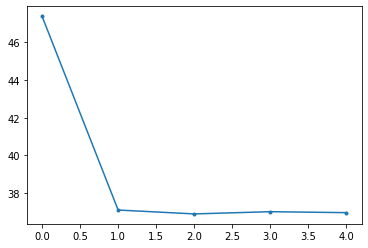

In [207]:
plt.plot(10*np.log10(np.abs(w)),'.-')